In [30]:
import os
import cv2
from tqdm import tqdm
from random import sample
from PIL import Image
import pickle
import time
import sys
import math

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset

from sklearn.metrics import accuracy_score
from sklearn import svm, metrics, preprocessing

np.set_printoptions(suppress=True)


In [2]:
!pip install mediapipe
!pip install timm==0.4.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 36.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 0.6.13
    Uninstalling timm-0.6.13:
      Successfully uninstalled timm-0.6.13


In [3]:
import mediapipe as mp

In [4]:
!pip install facenet-pytorch
from facenet_pytorch import MTCNN # pretrained model for image recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.9 MB/s eta 0:00:00a 0:00:01


In [5]:
from shutil import copyfile

copyfile(src = "../input/mtcnn-model/facial_analysis_kaggle.py", dst = "../working/facial_analysis_kaggle.py")
copyfile(src = "../input/mtcnn-model/mtcnn.pb", dst = "../working/mtcnn.pb")

'../working/mtcnn.pb'

In [6]:
from facial_analysis_kaggle import FacialImageProcessing

imgProcessing = FacialImageProcessing(False)
mtcnn = MTCNN(keep_all=True, min_face_size=40, device='cpu')

/kaggle/working/mtcnn.pb


In [45]:
def extract_and_save_faces(data_path, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for person in tqdm(os.listdir(data_path)):
        person_path = data_path + '/' + person
        # print(person_path)
        if not os.path.exists(save_dir + '/' + person):
            os.makedirs(save_dir + '/' + person)
        for video_name in os.listdir(person_path):
            video_format = list(os.listdir(person_path + '/' + video_name))[0].split('.')[-1]
            video_path = person_path + '/' + video_name + '/' + video_name + '.' + video_format
            video = cv2.VideoCapture(video_path)
            fps = video.get(cv2.CAP_PROP_FPS)
            images = []
            filenames = []
            i = 0.
            stride = 1.0
            
            frame_times = []

            while video.isOpened():
                ret, frame = video.read()
                if ret:
                    images.append(frame)
                    frame_times.append(i)
                    i += stride
                    video.set(1, round(i * fps))
                else:
                    video.release()
                    break
                    
            for i, image in enumerate(images):
                bounding_boxes, _ = imgProcessing.detect_faces(image)
                # bounding_boxes, _, _ = mtcnn.detect(image, landmarks=True)
                
                if bounding_boxes is None or len(bounding_boxes)==0:
                    # print('No faces found for ',video_path + '_' + str(i+1))
                    face_img = image
                    faceFound='noface'
                else:
                    if len(bounding_boxes)>1:
                        # print('Too many faces (',len(bounding_boxes),') found for ',filename)
                        bounding_boxes=bounding_boxes[:1]
                    
                    b=[int(bi) for bi in bounding_boxes[0]]
                    x1,y1,x2,y2=b[0:4]
                    face_img=image[y1:y2,x1:x2,:]
                    
                    if np.prod(face_img.shape)==0:
                        # print('Empty face ',b,' found for ',filename)
                        continue
                        
                    faceFound=''

                # print('/kaggle/working/daisee_test/' + person + '/' + video_name + '_' + str(i+1) + '_' + faceFound + '.png')
                cv2.imwrite(save_dir + '/' + person + '/' + video_name + '_' + str(i+1) + '_' + faceFound + '.png', face_img)
                # cv2.imwrite(os.path.join(save_path, folder, root+faceFound+ext), face_img)

In [7]:
train_video_path = r'/kaggle/input/daisee/DAiSEE/DataSet/Train'
val_video_path = r'/kaggle/input/daisee/DAiSEE/DataSet/Validation'
test_video_path = r'/kaggle/input/daisee/DAiSEE/DataSet/Test'

In [ ]:
extract_and_save_faces(train_video_path, r'/kaggle/working/daisee_train')

In [ ]:
extract_and_save_faces(val_video_path, r'/kaggle/working/daisee_val')

In [115]:
# extract_and_save_faces(test_video_path)

100%|██████████| 21/21 [29:45<00:00, 85.01s/it] 


Что нужно для качественного завершения вкр:
- лица DAiSEE всех трех выборок
- определяем точку, куда в основном смотрят чуваки разных классов на DAiSEE 
- определяем их поворот по x и y
- определяем средний ratio глаза (проверить на наличие азиатов)

Так понимаем на train понимаем, какие признаки у каких классов в какую сторону смещены.
Затем подбираем пороговые значения, делаем классификацию, замеряем метрики******

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [17]:
def load_gaze_tracker(model_path: str):
    model = torch.load(model_path, map_location = torch.device('cpu'))
    # model = torchvision.models.efficientnet_b0(pretrained = False)
    # model.classifier = nn.Linear(1280, 9, bias = True)
    # model = torchvision.models.alexnet(pretrained = False)
    # model.classifier[6] = nn.Linear(4096, 9)
    if device == 'cuda:0':
        model.to(device)
    # model.load_state_dict(torch.load(model_path, map_location = torch.device('cpu')))
    model.eval()

    return model

In [18]:
torch.cuda.is_available()

True

In [89]:
RIGHT_EYE_INDEXES = [33, 133, 145, 159] # порядок важен
LEFT_EYE_INDEXES = [263, 362, 374, 386] # порядок важен
FACE_INDEXES = [33, 263, 1, 61, 291, 199]

def get_blink_ratio(img, right_eye_coords, left_eye_coords):
    # right eye horizontal line 
    rh_right = right_eye_coords[0] # 33
    rh_left = right_eye_coords[1] # 133

    # right eye vertical line 
    rv_top = right_eye_coords[3] # 159
    rv_bottom = right_eye_coords[2] # 145

    # cv2.line(img, rh_right, rh_left, (0, 0, 255), 2)
    #  cv2.line(img, rv_top, rv_bottom, (0, 0, 255), 2)

    # left eye horizontal line 
    lh_right = left_eye_coords[1] # 362
    lh_left = left_eye_coords[0] # 263

    # left eye vertical line 
    lv_top = left_eye_coords[3] # 386
    lv_bottom = left_eye_coords[2] # 374

    rhDistance = get_euclaidean_distance(rh_right, rh_left) + 0.00001
    rvDistance = get_euclaidean_distance(rv_top, rv_bottom) + 0.00001

    lvDistance = get_euclaidean_distance(lv_top, lv_bottom) + 0.00001
    lhDistance = get_euclaidean_distance(lh_right, lh_left) + 0.00001

    reRatio = rhDistance / rvDistance
    leRatio = lhDistance / lvDistance

    ratio = (reRatio + leRatio) / 2
    return ratio 

def get_euclaidean_distance(point, point1):
    x, y = point
    x1, y1 = point1
    distance = math.sqrt((x1 - x)**2 + (y1 - y)**2)
    return distance

In [90]:
def get_params(data_path, save_dir, label_path):
    gaze_tracker = load_gaze_tracker('/kaggle/input/dgw-enet-models/enet_b0_sota.pt')
    result_df = pd.DataFrame(columns=['frame_name', 'X', 'Y', 'gaze_ratio', 'face_detected', 'prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5', 'prob_6', 'prob_7', 'prob_8', 'prob_9', 'pred_gaze_point'])
    transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize((260, 260), antialias=True),
                # torchvision.transforms.RandomHorizontalFlip(p=1), # оставить при работе с вебки
                # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            # std=[0.229, 0.224, 0.225])
            ]
        )
    
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    mp_drawing = mp.solutions.drawing_utils

    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for person in tqdm(os.listdir(data_path)):
        person_path = data_path + '/' + person
        # print(person_path)
        if not os.path.exists(save_dir + '/' + person):
            os.makedirs(save_dir + '/' + person)
        for video_name in os.listdir(person_path):
            video_format = list(os.listdir(person_path + '/' + video_name))[0].split('.')[-1]
            video_path = person_path + '/' + video_name + '/' + video_name + '.' + video_format
            video = cv2.VideoCapture(video_path)
            fps = video.get(cv2.CAP_PROP_FPS)
            
            images = []
            filenames = []
            i = 0.
            stride = 1.0
            
            frame_times = []

            while video.isOpened():
                ret, frame = video.read()
                if ret:
                    images.append(frame)
                    frame_times.append(i)
                    i += stride
                    video.set(1, round(i * fps))
                else:
                    video.release()
                    break
                
            for i, image in enumerate(images):
                data_row = [video_name + '_' + str(i+1)]
                image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
                # To improve performance
                image.flags.writeable = False
                # Get the result
                results = face_mesh.process(image)
                # To improve performance
                image.flags.writeable = True

                # Convert the color space from RGB to BGR
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                
                img_h, img_w, img_c = image.shape
                
                face_3d = []
                face_2d = []

                left_eye_2d = []
                right_eye_2d = []

                if results.multi_face_landmarks:
                    for face_landmarks in results.multi_face_landmarks:
                        # у каждого кадра берем только 6 нужных нам точек
                        for idx, lm in enumerate(face_landmarks.landmark):
                            if idx in FACE_INDEXES:
                                x, y = int(lm.x * img_w), int(lm.y * img_h)

                                # Get the 2D Coordinates
                                face_2d.append([x, y])

                                # Get the 3D Coordinates
                                face_3d.append([x, y, lm.z])

                            if idx in RIGHT_EYE_INDEXES:
                                x, y = int(lm.x * img_w), int(lm.y * img_h)

                                right_eye_2d.append([x, y])

                            if idx in LEFT_EYE_INDEXES:
                                x, y = int(lm.x * img_w), int(lm.y * img_h)

                                left_eye_2d.append([x, y])

                    # blink ratio
                    ratio = get_blink_ratio(image, right_eye_2d, left_eye_2d) 
                    # print(ratio)   

                    # Convert it to the NumPy array
                    face_2d = np.array(face_2d, dtype=np.float64)

                    # Convert it to the NumPy array
                    face_3d = np.array(face_3d, dtype=np.float64)

                    # The camera matrix
                    focal_length = 2.2

                    # Have to calibrate camera to get cam_matrix
                    cam_matrix = np.array([ [focal_length, 0, img_h / 2], 
                                            [0, focal_length, img_w / 2], 
                                            [0, 0, 1]])
                    
                    dist_matrix = np.zeros((4, 1), dtype=np.float64)

                    # Solve PnP
                    _, rot_vec, translation_vector = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

                    # Get rotation matrix
                    rmat, _ = cv2.Rodrigues(rot_vec)

                    # Get angles
                    angles, _, _, _, _, _ = cv2.RQDecomp3x3(rmat)

                    # Get the y rotation degree
                    x = angles[0] * 360
                    y = angles[1] * 360
                
                    data_row.append(x)
                    data_row.append(y)
                    data_row.append(ratio)
                else:
                    data_row.append('Nan')
                    data_row.append('Nan')
                    data_row.append('Nan')
                
                bounding_boxes, _ = imgProcessing.detect_faces(image)
                # bounding_boxes, _, _ = mtcnn.detect(image, landmarks=True)
                
                if bounding_boxes is None or len(bounding_boxes)==0:
                    # print('No faces found for ',video_path + '_' + str(i+1))
                    face_img = image
                    faceFound='noface'
                    data_row.append(faceFound)
                    data_row += ['-' for i in range(10)]
                else:
                    if len(bounding_boxes)>1:
                        # print('Too many faces (',len(bounding_boxes),') found for ',filename)
                        bounding_boxes=bounding_boxes[:1]
                    
                    b=[int(bi) for bi in bounding_boxes[0]]
                    x1,y1,x2,y2=b[0:4]
                    face_img=image[y1:y2,x1:x2,:]
                    
                    if np.prod(face_img.shape)==0:
                        # print('Empty face ',b,' found for ',filename)
                        continue
                        
                    faceFound=''
                    data_row.append(faceFound)
                    
                    face_img = cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR)
                    face_transformed = transform(face_img)
                    # face_transformed.to(device)
                    face_transformed = torch.unsqueeze(face_transformed, 0)
                    face_transformed = face_transformed.to(device)
                        
                    predicted_gaze_direction = gaze_tracker(face_transformed)
                    pred_gaze_point = predicted_gaze_direction.argmax(1).cpu().detach().item()
                    probs = F.softmax(predicted_gaze_direction, dim=1)# .topk(9, dim = 1)
                    # print(probs[0].detach().numpy())
                    # print(data_row)
                    data_row += list(probs[0].detach().numpy())
                    data_row.append(pred_gaze_point)
                    
                    
                # print(data_row)
                # print(len(data_row))
                # plt.figure(figsize = [15,10])
                # plt.imshow(image); plt.axis('off'); plt.title("Image with bbox")
                
                result_df.loc[len(result_df.index)] = data_row
                
            # break
        # break
                
                # result_df.loc[len(result_df.index)] = data_row
                # print('/kaggle/working/daisee_test/' + person + '/' + video_name + '_' + str(i+1) + '_' + faceFound + '.png')
                # cv2.imwrite(save_dir + '/' + person + '/' + video_name + '_' + str(i+1) + '_' + faceFound + '.png', face_img)
                # cv2.imwrite(os.path.join(save_path, folder, root+faceFound+ext), face_img)
                
    return result_df

In [87]:
pd.read_csv('/kaggle/input/daisee/DAiSEE/Labels/TrainLabels.csv')

,ClipID,Boredom,Engagement,Confusion,Frustration
0,1100011002.avi,0,2,0,0
1,1100011003.avi,0,2,0,0
2,1100011004.avi,0,3,0,0
3,1100011005.avi,0,3,0,0
4,1100011006.avi,0,3,0,0
...,...,...,...,...,...
5353,4599990246.avi,0,3,0,0
5354,4599990247.avi,0,3,0,0
5355,4599990248.avi,1,2,1,1
5356,4599990249.avi,0,3,0,0


In [91]:
train_features = get_params(train_video_path, r'/kaggle/working/daisee_train', '/kaggle/input/daisee/DAiSEE/Labels/TrainLabels.csv')

 24%|██▍       | 17/70 [33:20<1:51:41, 126.44s/it][mpeg4 @ 0x56f77f9cfe40] I cbpy damaged at 16 8
[mpeg4 @ 0x56f77f9cfe40] Error at MB: 344
100%|██████████| 70/70 [2:23:19<00:00, 122.85s/it]  


In [92]:
with open(r'/kaggle/working/daisee_train_features', 'wb') as handle:
    pickle.dump(train_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [154]:
with open(r"/kaggle/working/daisee_train_features", "rb") as input_file:
    train_features = pickle.load(input_file)

In [155]:
train_features.head()

,frame_name,X,Y,gaze_ratio,face_detected,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,pred_gaze_point
0,2056010245_1,1.458831,8.607171,3.286633,,0.011467,0.028972,0.833906,0.014621,0.000008,0.001165,0.00108,0.001185,0.107597,2
1,2056010245_2,2.98601,7.835864,3.139347,,0.019213,0.035593,0.807437,0.011119,0.000015,0.00163,0.001643,0.002076,0.121275,2
2,2056010245_3,1.444122,7.60535,3.221078,,0.016068,0.032793,0.812302,0.012679,0.000014,0.00167,0.001646,0.001863,0.120965,2
3,2056010245_4,1.947624,7.917196,3.132607,,0.011271,0.038721,0.823888,0.00836,0.000005,0.000747,0.000772,0.000869,0.115367,2
4,2056010245_5,2.822495,7.732801,3.64591,,0.01292,0.032773,0.848921,0.018209,0.000012,0.00111,0.001165,0.001262,0.083628,2


In [156]:
train_labels = pd.read_csv('/kaggle/input/daisee/DAiSEE/Labels/TrainLabels.csv')[['ClipID', 'Engagement']]
train_labels['ClipID'] = train_labels['ClipID'].apply(lambda x: x.split('.')[0])

In [157]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5358 entries, 0 to 5357
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ClipID      5358 non-null   object
 1   Engagement  5358 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 83.8+ KB


In [158]:
train_labels.head()

,ClipID,Engagement
0,1100011002,2
1,1100011003,2
2,1100011004,3
3,1100011005,3
4,1100011006,3


In [159]:
train_features.shape

(55002, 15)

In [160]:
train_features[train_features.face_detected != 'noface'].shape

(52238, 15)

In [161]:
train_features = train_features[train_features.face_detected != 'noface']
# train_features = train_features.drop(['frame_name', 'face_detected'], axis = 0)

In [162]:
train_features = train_features[train_features.X != 'Nan']

In [163]:
train_features = train_features[train_features.Y != 'Nan']
train_features = train_features[train_features.gaze_ratio != 'Nan']

In [164]:
train_features.shape

(52079, 15)

In [165]:
train_features['frame_name'] = train_features['frame_name'].apply(lambda x: x.split('_')[0])

In [166]:
train_features.head()

,frame_name,X,Y,gaze_ratio,face_detected,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,pred_gaze_point
0,2056010245,1.458831,8.607171,3.286633,,0.011467,0.028972,0.833906,0.014621,0.000008,0.001165,0.00108,0.001185,0.107597,2
1,2056010245,2.98601,7.835864,3.139347,,0.019213,0.035593,0.807437,0.011119,0.000015,0.00163,0.001643,0.002076,0.121275,2
2,2056010245,1.444122,7.60535,3.221078,,0.016068,0.032793,0.812302,0.012679,0.000014,0.00167,0.001646,0.001863,0.120965,2
3,2056010245,1.947624,7.917196,3.132607,,0.011271,0.038721,0.823888,0.00836,0.000005,0.000747,0.000772,0.000869,0.115367,2
4,2056010245,2.822495,7.732801,3.64591,,0.01292,0.032773,0.848921,0.018209,0.000012,0.00111,0.001165,0.001262,0.083628,2


In [ ]:
train_features.groupby(['frame_name']).agg({
    'X': {'X_mean': 'mean', 'X_std': 'std'}, 
    'Y': {'Y_mean': 'mean', 'Y_std': 'std'}, 
    'gaze_ratio': {'gaze_ratio_mean': 'mean', 'gaze_ratio_std': 'std'}, 
    'prob_1': {'prob_1_mean': 'mean', 'prob_1_std': 'std'}, 
    'prob_2': {'prob_2_mean': 'mean', 'prob_2_std': 'std'}, 
    'prob_3': {'prob_3_mean': 'mean', 'prob_3_std': 'std'}, 
    'prob_4': {'prob_4_mean': 'mean', 'prob_4_std': 'std'}, 
    'prob_5': {'prob_5_mean': 'mean', 'prob_5_std': 'std'}, 
    'prob_6': {'prob_6_mean': 'mean', 'prob_6_std': 'std'}, 
    'prob_7': {'prob_7_mean': 'mean', 'prob_7_std': 'std'}, 
    'prob_8': {'prob_8_mean': 'mean', 'prob_8_std': 'std'}, 
    'prob_9': {'prob_9_mean': 'mean', 'prob_9_std': 'std'},
    'pred_gaze_point': {'pred_gaze_point_mean': 'mean', 'pred_gaze_point_std': 'std'}
})

In [167]:
train_features = train_features.groupby(['frame_name']).agg({
    'X': ['mean', 'std'],
    'Y': ['mean', 'std'],
    'gaze_ratio': ['mean', 'std'],
    'prob_1': ['mean', 'std'],
    'prob_2': ['mean', 'std'],
    'prob_3': ['mean', 'std'],
    'prob_4': ['mean', 'std'],
    'prob_5': ['mean', 'std'],
    'prob_6': ['mean', 'std'],
    'prob_7': ['mean', 'std'],
    'prob_8': ['mean', 'std'],
    'prob_9': ['mean', 'std'],
    'pred_gaze_point': ['mean', 'std'],
})

In [168]:
train_features.columns = train_features.columns.droplevel(0)

In [169]:
train_features = train_features.dropna()

In [170]:
train_features.shape

(5370, 26)

In [171]:
train_features = pd.merge(train_features, train_labels, left_on=["frame_name"], right_on=['ClipID'], how='inner')

In [172]:
train_features = train_features.drop(['ClipID'], axis=1)

In [173]:
train_features.shape

(5264, 27)

In [ ]:
train_cols = ['X', 'Y', 'gaze_ratio', 'prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5', 'prob_6', 'prob_7', 'prob_8', 'prob_9', 'pred_gaze_point']

In [175]:
train_features[['mean', 'std']].head()

,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,std,std,std,std,std,std,std,std,std,std
0,4.986976,6.635382,3.592299,0.002661,0.008042,0.957971,0.008104,6.066828e-06,0.000694,0.001066,...,0.003551,0.012904,0.039395,0.013417,1.306906e-05,0.000579,0.001079,0.001064,0.014124,0.000000
1,2.509634,10.241833,3.215722,0.002715,0.004800,0.969968,0.003753,9.423606e-07,0.000866,0.001086,...,0.001792,0.003873,0.011128,0.003395,1.299785e-06,0.000367,0.000511,0.000366,0.006792,0.000000
2,1.911733,9.791538,3.269710,0.005243,0.008258,0.956032,0.005605,2.449132e-06,0.001657,0.001846,...,0.003248,0.004263,0.022753,0.006093,2.892174e-06,0.001363,0.001525,0.001138,0.007666,0.000000
3,2.626298,8.115982,3.464455,0.002297,0.002537,0.979349,0.000932,2.404367e-07,0.000550,0.000614,...,0.001296,0.001855,0.005203,0.000582,1.657552e-07,0.000109,0.000219,0.000234,0.004188,0.000000
4,4.754124,5.497102,3.969936,0.007433,0.004466,0.828424,0.003548,6.272386e-04,0.009018,0.011030,...,0.020867,0.009094,0.259509,0.008663,1.983109e-03,0.027138,0.033917,0.044829,0.137732,1.897367


In [179]:
train_features.columns = ['X_mean', 'X_std','Y_mean', 'Y_std', 'gaze_ratio_mean', 'gaze_ratio_std','prob_1_mean', 'prob_1_std', 'prob_2_mean', 'prob_2_std', 'prob_3_mean', 'prob_3_std',
                         'prob_4_mean', 'prob_4_std', 'prob_5_mean', 'prob_5_std', 'prob_6_mean', 'prob_6_std', 'prob_7_mean', 'prob_7_std', 'prob_8_mean',
                          'prob_8_std', 'prob_9_mean', 'prob_9_std', 'pred_gaze_point_mean', 'pred_gaze_point_std', 'Engagement']

In [180]:
train_features.head()

,X_mean,X_std,Y_mean,Y_std,gaze_ratio_mean,gaze_ratio_std,prob_1_mean,prob_1_std,prob_2_mean,prob_2_std,...,prob_6_std,prob_7_mean,prob_7_std,prob_8_mean,prob_8_std,prob_9_mean,prob_9_std,pred_gaze_point_mean,pred_gaze_point_std,Engagement
0,4.986976,1.681956,6.635382,3.815230,3.592299,0.349920,0.002661,0.003551,0.008042,0.012904,...,0.000579,0.001066,0.001079,0.001001,0.001064,0.020454,0.014124,2.0,0.000000,2
1,2.509634,0.986514,10.241833,1.498707,3.215722,0.204325,0.002715,0.001792,0.004800,0.003873,...,0.000367,0.001086,0.000511,0.000940,0.000366,0.015871,0.006792,2.0,0.000000,2
2,1.911733,0.624217,9.791538,1.475655,3.269710,0.261602,0.005243,0.003248,0.008258,0.004263,...,0.001363,0.001846,0.001525,0.001609,0.001138,0.019747,0.007666,2.0,0.000000,3
3,2.626298,1.844672,8.115982,1.287168,3.464455,0.387587,0.002297,0.001296,0.002537,0.001855,...,0.000109,0.000614,0.000219,0.000827,0.000234,0.012894,0.004188,2.0,0.000000,3
4,4.754124,1.812147,5.497102,5.978201,3.969936,0.603675,0.007433,0.020867,0.004466,0.009094,...,0.027138,0.011030,0.033917,0.014592,0.044829,0.120862,0.137732,2.6,1.897367,3


In [181]:
X_train = train_features[list(train_features.columns)[:len(train_features.columns)-1]]
y_train = train_features['Engagement']

In [189]:
test_features = get_params(test_video_path, r'/kaggle/working/daisee_test', '/kaggle/input/daisee/DAiSEE/Labels/TestLabels.csv')

100%|██████████| 21/21 [47:36<00:00, 136.05s/it]


In [191]:
with open(r'/kaggle/working/daisee_test_features', 'wb') as handle:
    pickle.dump(test_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [192]:
test_labels = pd.read_csv('/kaggle/input/daisee/DAiSEE/Labels/TestLabels.csv')[['ClipID', 'Engagement']]
test_labels['ClipID'] = test_labels['ClipID'].apply(lambda x: x.split('.')[0])

In [193]:
test_features = test_features[test_features.face_detected != 'noface']
test_features = test_features[test_features.X != 'Nan']
test_features = test_features[test_features.Y != 'Nan']
test_features = test_features[test_features.gaze_ratio != 'Nan']

In [194]:
test_features['frame_name'] = test_features['frame_name'].apply(lambda x: x.split('_')[0])

In [195]:
test_features = test_features.groupby(['frame_name']).agg({
    'X': ['mean', 'std'],
    'Y': ['mean', 'std'],
    'gaze_ratio': ['mean', 'std'],
    'prob_1': ['mean', 'std'],
    'prob_2': ['mean', 'std'],
    'prob_3': ['mean', 'std'],
    'prob_4': ['mean', 'std'],
    'prob_5': ['mean', 'std'],
    'prob_6': ['mean', 'std'],
    'prob_7': ['mean', 'std'],
    'prob_8': ['mean', 'std'],
    'prob_9': ['mean', 'std'],
    'pred_gaze_point': ['mean', 'std'],
})

In [196]:
test_features.columns = test_features.columns.droplevel(0)

In [197]:
test_features = test_features.dropna()

In [200]:
test_features.head()

,mean,std,mean,std,mean,std,mean,std,mean,std,...,mean,std,mean,std,mean,std,mean,std,mean,std
frame_name,,,,,,,,,,,,,,,,,,,,,
5000441001,8.708634,2.284437,1.169482,1.852382,4.365009,3.142303,0.034277,0.028980,0.116912,0.135226,...,0.013548,0.010846,0.011118,0.009493,0.018977,0.016673,0.146738,0.092748,2.7,1.946507
5000441002,8.861622,0.526732,0.754212,1.898199,6.734597,5.563921,0.065733,0.095550,0.107858,0.107010,...,0.019366,0.013511,0.013352,0.011174,0.025097,0.021227,0.128571,0.057945,1.9,0.316228
5000441003,8.918761,1.320857,0.284092,0.562318,3.986572,1.544696,0.012750,0.006785,0.039972,0.015940,...,0.009646,0.003194,0.006769,0.002049,0.009054,0.003151,0.107037,0.035946,2.2,0.421637
5000441005,8.941153,0.565878,0.646843,0.353760,3.483150,0.254801,0.023170,0.015696,0.066051,0.031984,...,0.016676,0.011143,0.009308,0.005937,0.014381,0.009831,0.105654,0.015638,2.3,0.483046
5000441006,8.169413,1.537519,0.531087,0.272077,3.336499,0.344972,0.023505,0.024856,0.067849,0.033765,...,0.012180,0.012725,0.007219,0.005908,0.013171,0.012738,0.121295,0.051156,2.3,0.483046


In [201]:
test_features = pd.merge(test_features, test_labels, left_on=["frame_name"], right_on=['ClipID'], how='inner')
test_features = test_features.drop(['ClipID'], axis=1)

In [202]:
test_features.columns = ['X_mean', 'X_std','Y_mean', 'Y_std', 'gaze_ratio_mean', 'gaze_ratio_std','prob_1_mean', 'prob_1_std', 'prob_2_mean', 'prob_2_std', 'prob_3_mean', 'prob_3_std',
                         'prob_4_mean', 'prob_4_std', 'prob_5_mean', 'prob_5_std', 'prob_6_mean', 'prob_6_std', 'prob_7_mean', 'prob_7_std', 'prob_8_mean',
                          'prob_8_std', 'prob_9_mean', 'prob_9_std', 'pred_gaze_point_mean', 'pred_gaze_point_std', 'Engagement']

In [203]:
X_test = test_features[list(test_features.columns)[:len(test_features.columns)-1]]
y_test = test_features['Engagement']

### Визуализации

<AxesSubplot: >

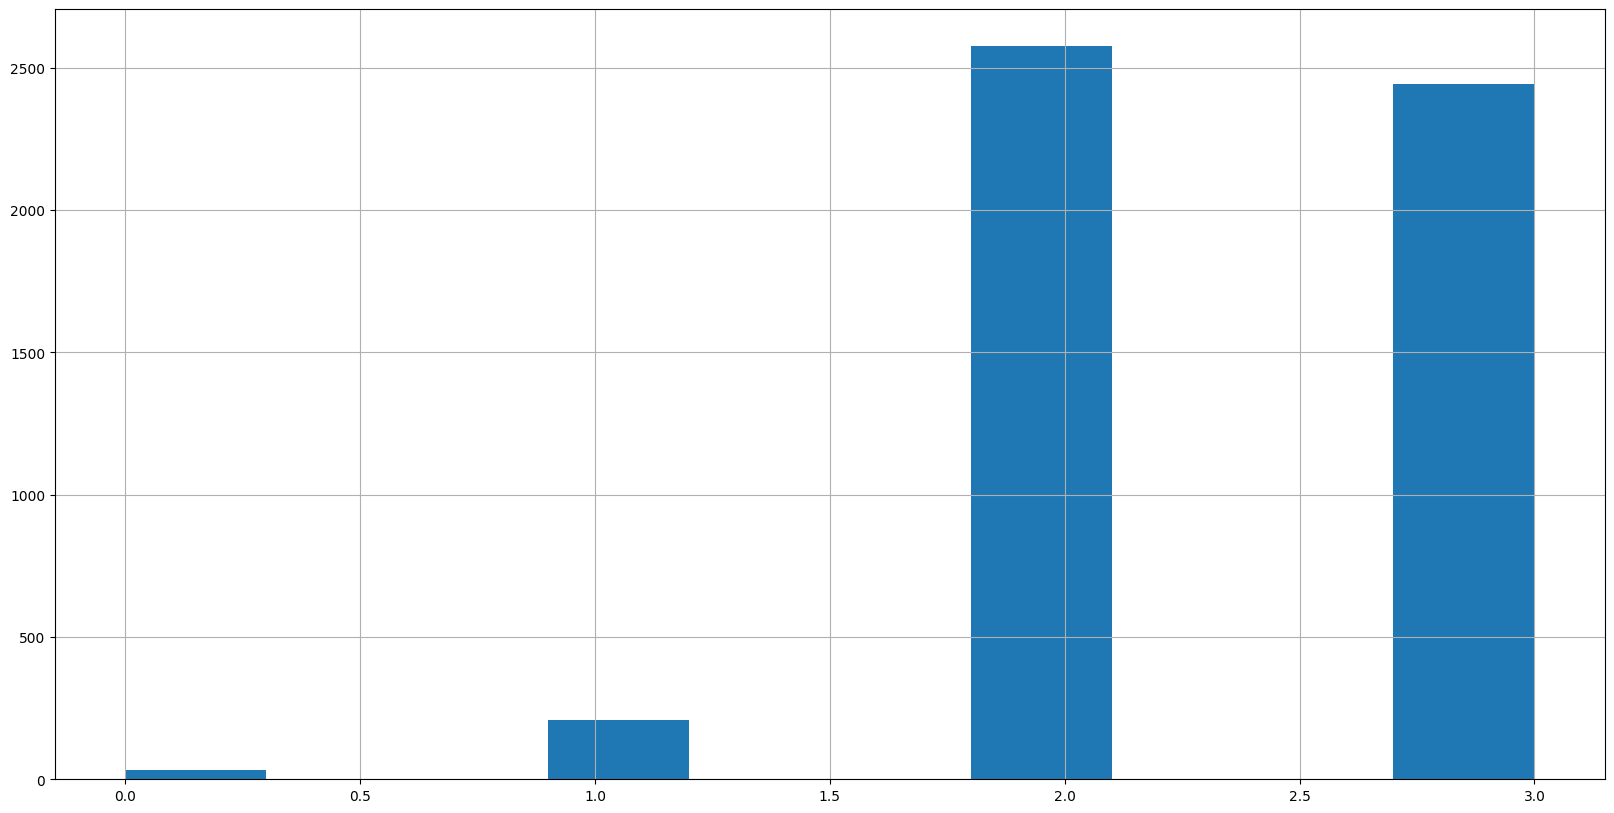

In [143]:
y_train.hist(figsize=((20, 10)))

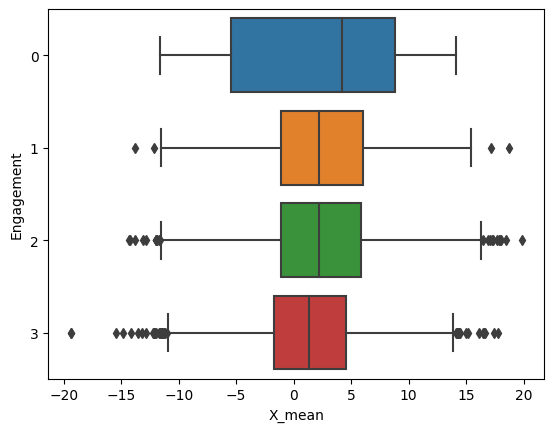

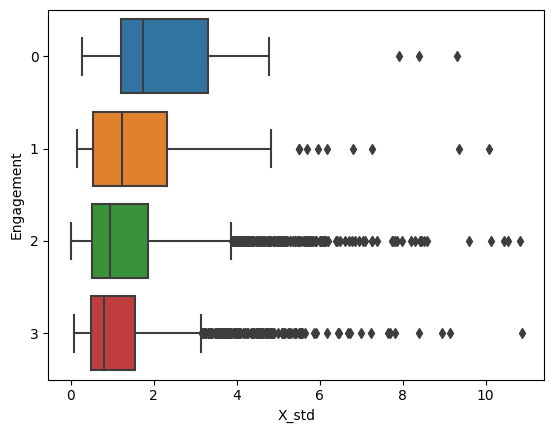

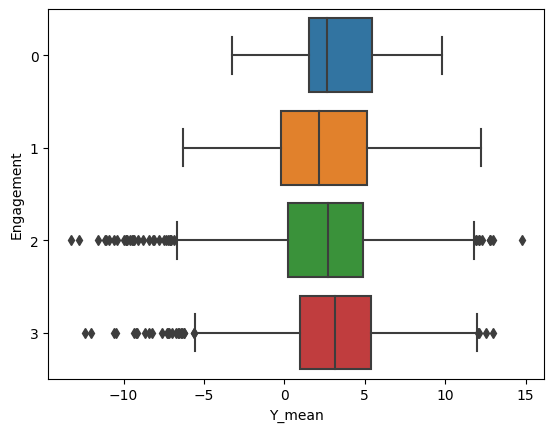

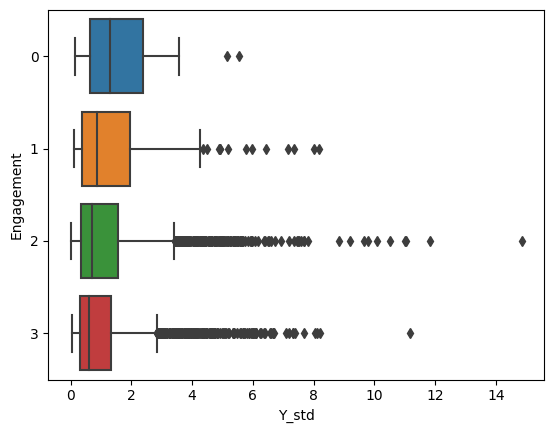

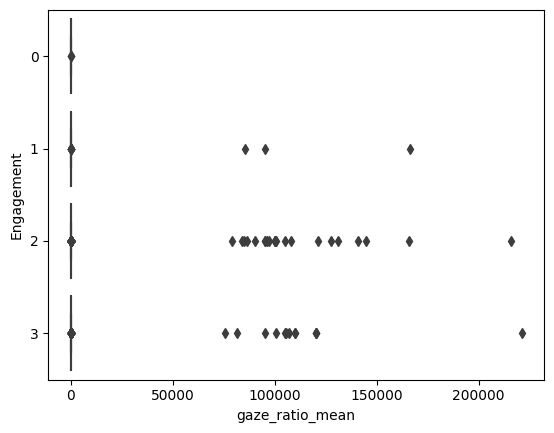

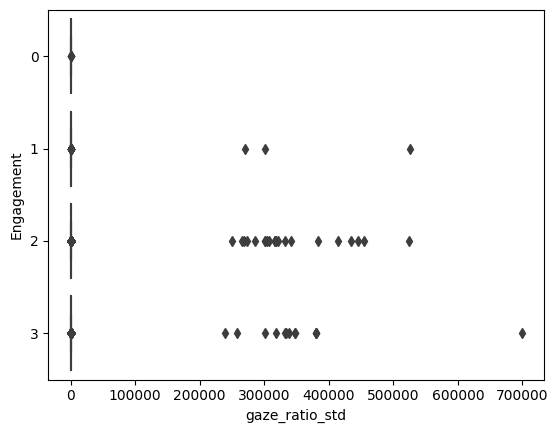

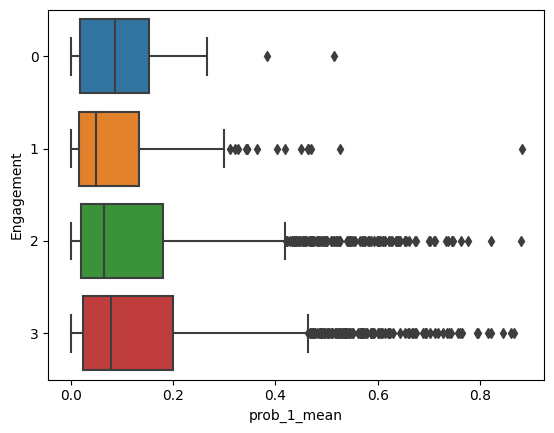

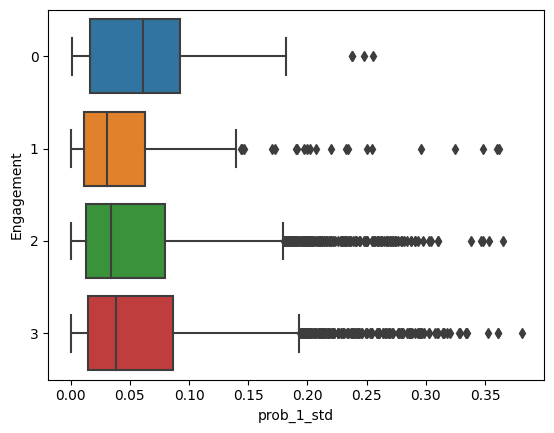

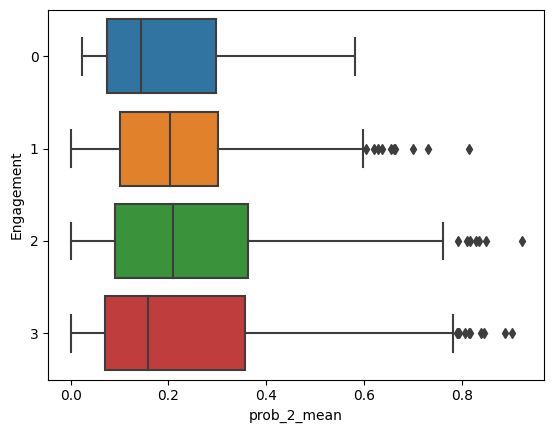

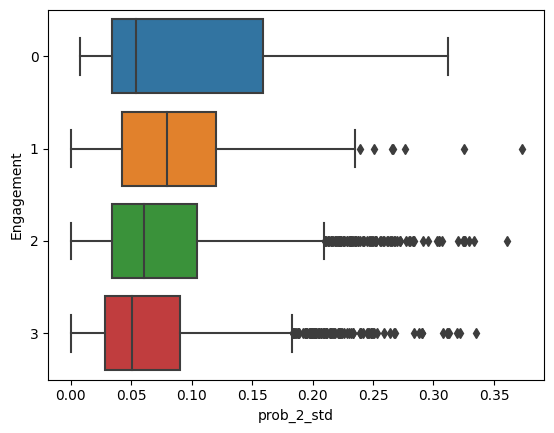

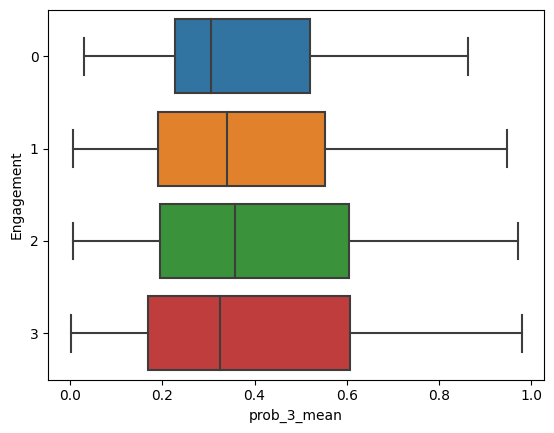

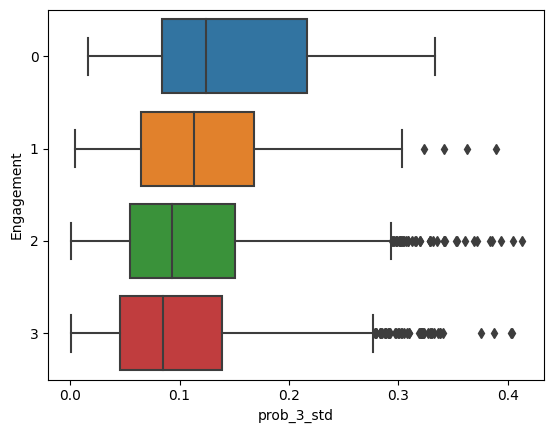

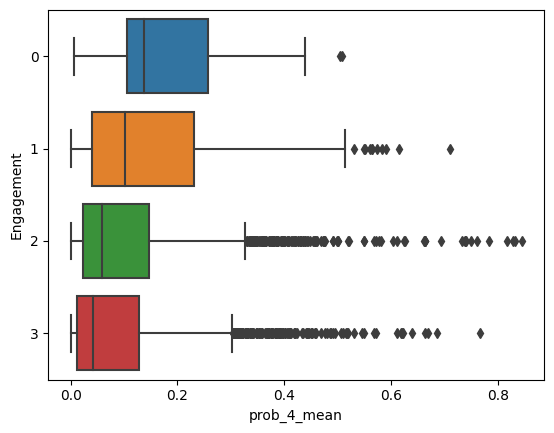

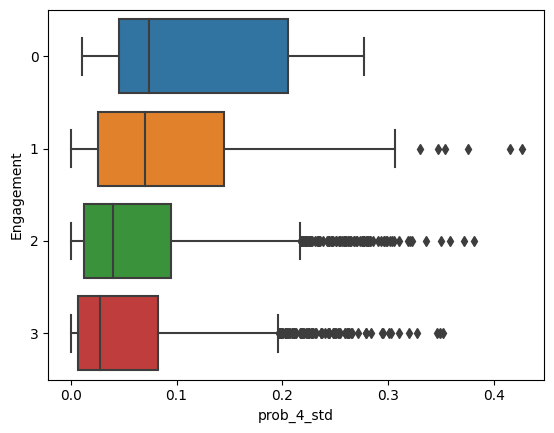

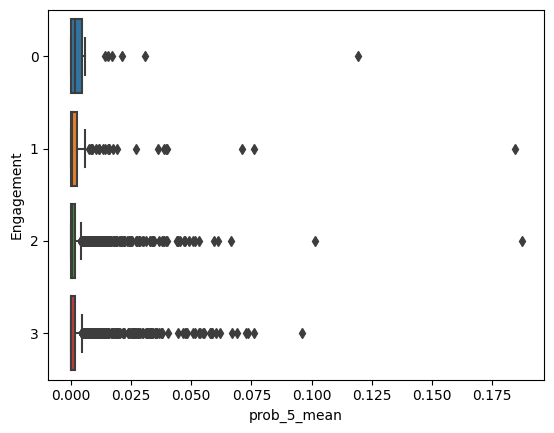

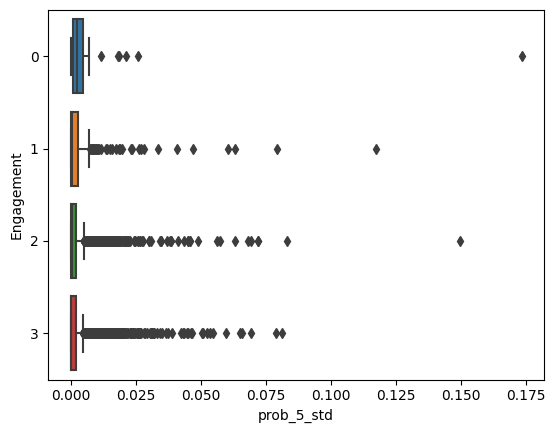

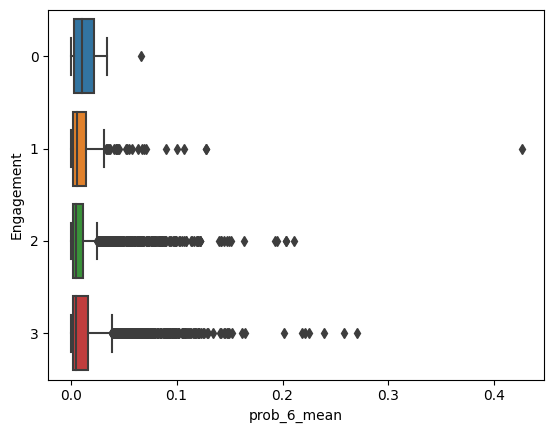

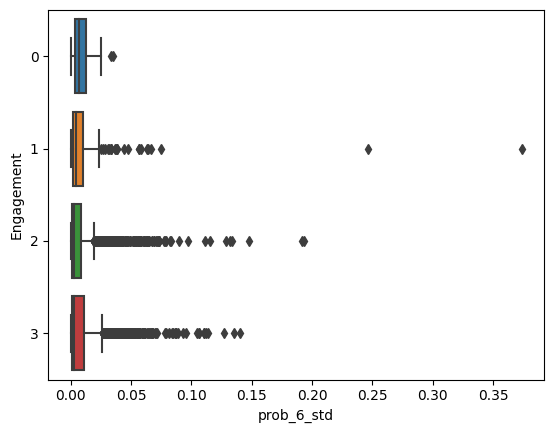

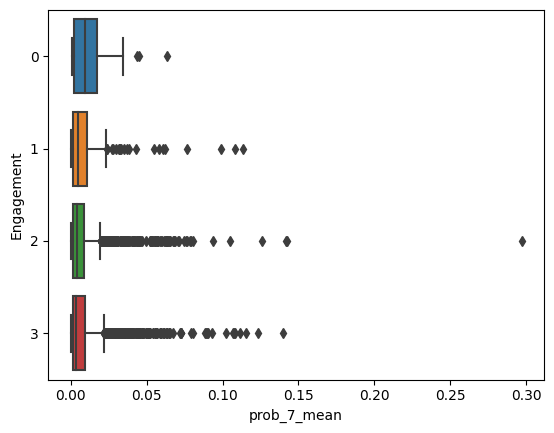

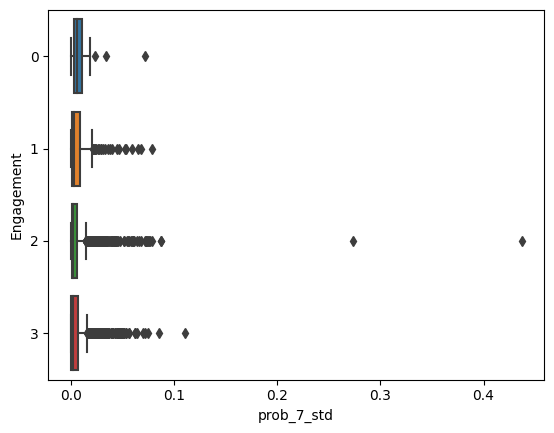

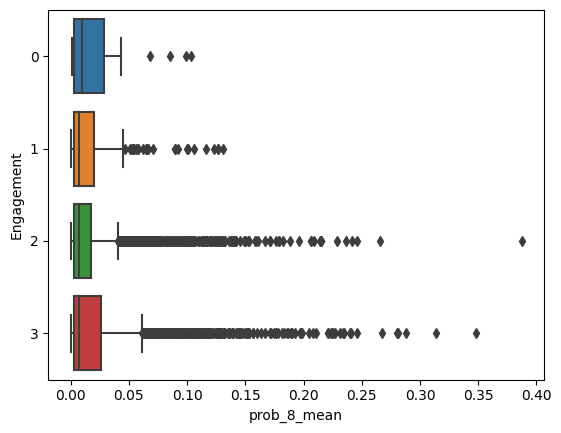

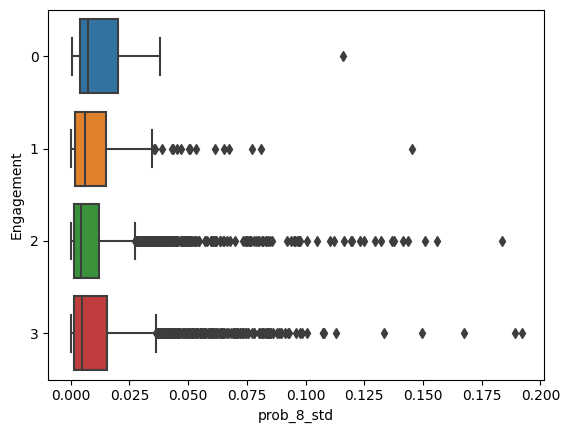

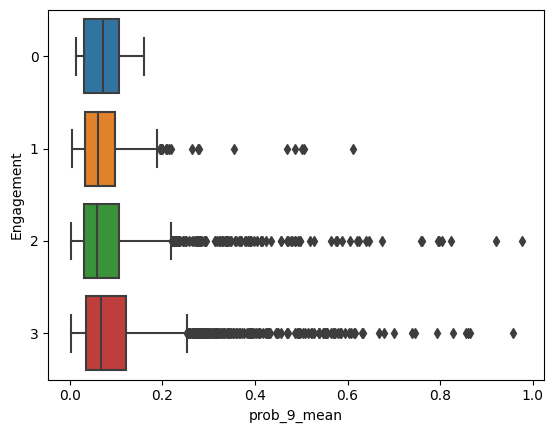

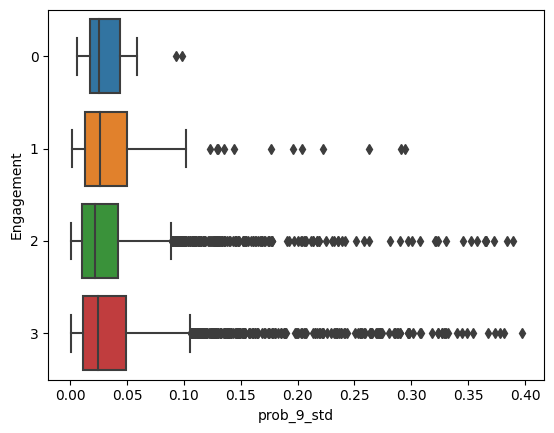

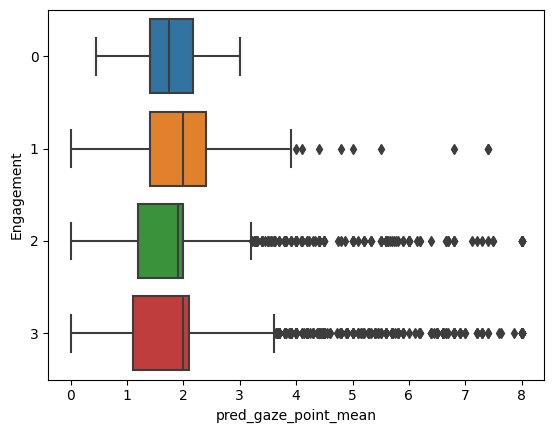

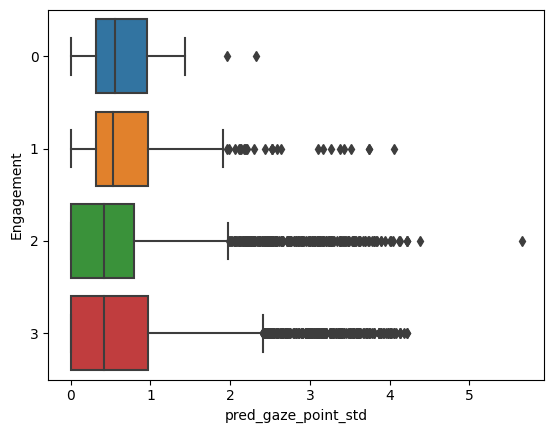

In [186]:
for col in X_train.columns:
    sns.boxplot(y = y_train.astype('category'), x = col, data = train_features)
    plt.show()

### Обучение и тестирование

In [204]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [205]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [208]:
lin_svc = LinearSVC()
lin_svc.fit(X_train_scaled, y_train)
y_pred_svc = lin_svc.predict(X_test_scaled)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [212]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        83
           2       0.47      0.49      0.48       871
           3       0.43      0.45      0.44       796

    accuracy                           0.45      1754
   macro avg       0.23      0.24      0.23      1754
weighted avg       0.43      0.45      0.44      1754



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [213]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_reg = log_reg.predict(X_test_scaled)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [216]:
print(classification_report(y_test, y_pred_reg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        83
           2       0.47      0.51      0.49       871
           3       0.43      0.43      0.43       796

    accuracy                           0.45      1754
   macro avg       0.23      0.24      0.23      1754
weighted avg       0.43      0.45      0.44      1754



In [217]:
X_test.shape

(1754, 26)

In [116]:
#import os
#os.chdir(r'/kaggle/working')

#!tar -czf daisee_test_faces.tar.gz daisee_test

#from IPython.display import FileLink

# FileLink(r'daisee_test_faces.tar.gz')

/kaggle/working/daisee_test_faces.tar.gz

In [112]:
# import shutil
# shutil.rmtree('/kaggle/working/daisee_test')